Notebook containing clusterings and associated visualizations.

## 1. Preliminary

### 1.1 Libraries

In [31]:
import pandas as pd
import numpy as np
from sklearn import decomposition, preprocessing, metrics, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import ks_2samp, shapiro, bartlett
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import datacompy

# Options pandas
pd.options.mode.chained_assignment = None

# Set plotting style
sns.set()

### 1.2 Data

In [2]:
# Load the data
df = pd.read_csv("df_for_cluster.csv")

# Drop France out of the countries
df = df[df["Zone"] != "France"]
df.set_index("Zone", inplace=True)

# Display the shape of the DataFrame
print("Number of countries:", df.shape[0])
print("Number of features:", df.shape[1])

Number of countries: 171
Number of features: 15


## 2. Data Exploration

In [3]:
# Copy DataFrame
X = df.copy()
display(X.head(3))

Population  Population_Growth   Emissions  Emissions_per_Capita  \
Zone                                                                           
Afghanistan   36296.113           0.032864   1646.2889              0.045357   
Albania        2884.169          -0.004542    906.7435              0.314386   
Algeria       41389.189           0.017248  11062.8003              0.267287   

                Distance  Compared_with_EUR  Exchange_Rate_Evolution  \
Zone                                                                   
Afghanistan  5585.579825          62.584752                -0.032702   
Albania      1549.151949         109.572000                -0.012120   
Algeria      2019.778162         102.095175                 0.027047   

                  CPI  CPI_Average_Evolution  Political Stability  \
Zone                                                                
Afghanistan  6.957529               0.132833                -2.80   
Albania      3.924577              -4.817490                 0.38   
Algeria      5.040496              -0.524376                -0.92   

             Poultry Availability  Poultry_Availability_per_Capita  \
Zone                                                                 
Afghanistan                   5.0                         0.000138   
Albania                      85.0                         0.029471   
Algeria                      22.0                         0.000532   

             Importations  Production  Domestic Availability  
Zone                                                          
Afghanistan          29.0        28.0                   57.0  
Albania              38.0        13.0                   47.0  
Algeria               2.0       275.0                  277.0

In [4]:
# Get feature names
features = X.columns
print("\nFeature names:")
print(features)


Feature names:
Index(['Population', 'Population_Growth', 'Emissions', 'Emissions_per_Capita',
       'Distance', 'Compared_with_EUR', 'Exchange_Rate_Evolution', 'CPI',
       'CPI_Average_Evolution', 'Political Stability', 'Poultry Availability',
       'Poultry_Availability_per_Capita', 'Importations', 'Production',
       'Domestic Availability'],
      dtype='object')


In [5]:
# Get zone names
zones = X.index
print("\nZone names (first 10):")
print(zones[:10])


Zone names (first 10):
Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan'],
      dtype='object', name='Zone')


### 2.1 Pairwise Correlation of Variables


Pairwise Scatter plot:


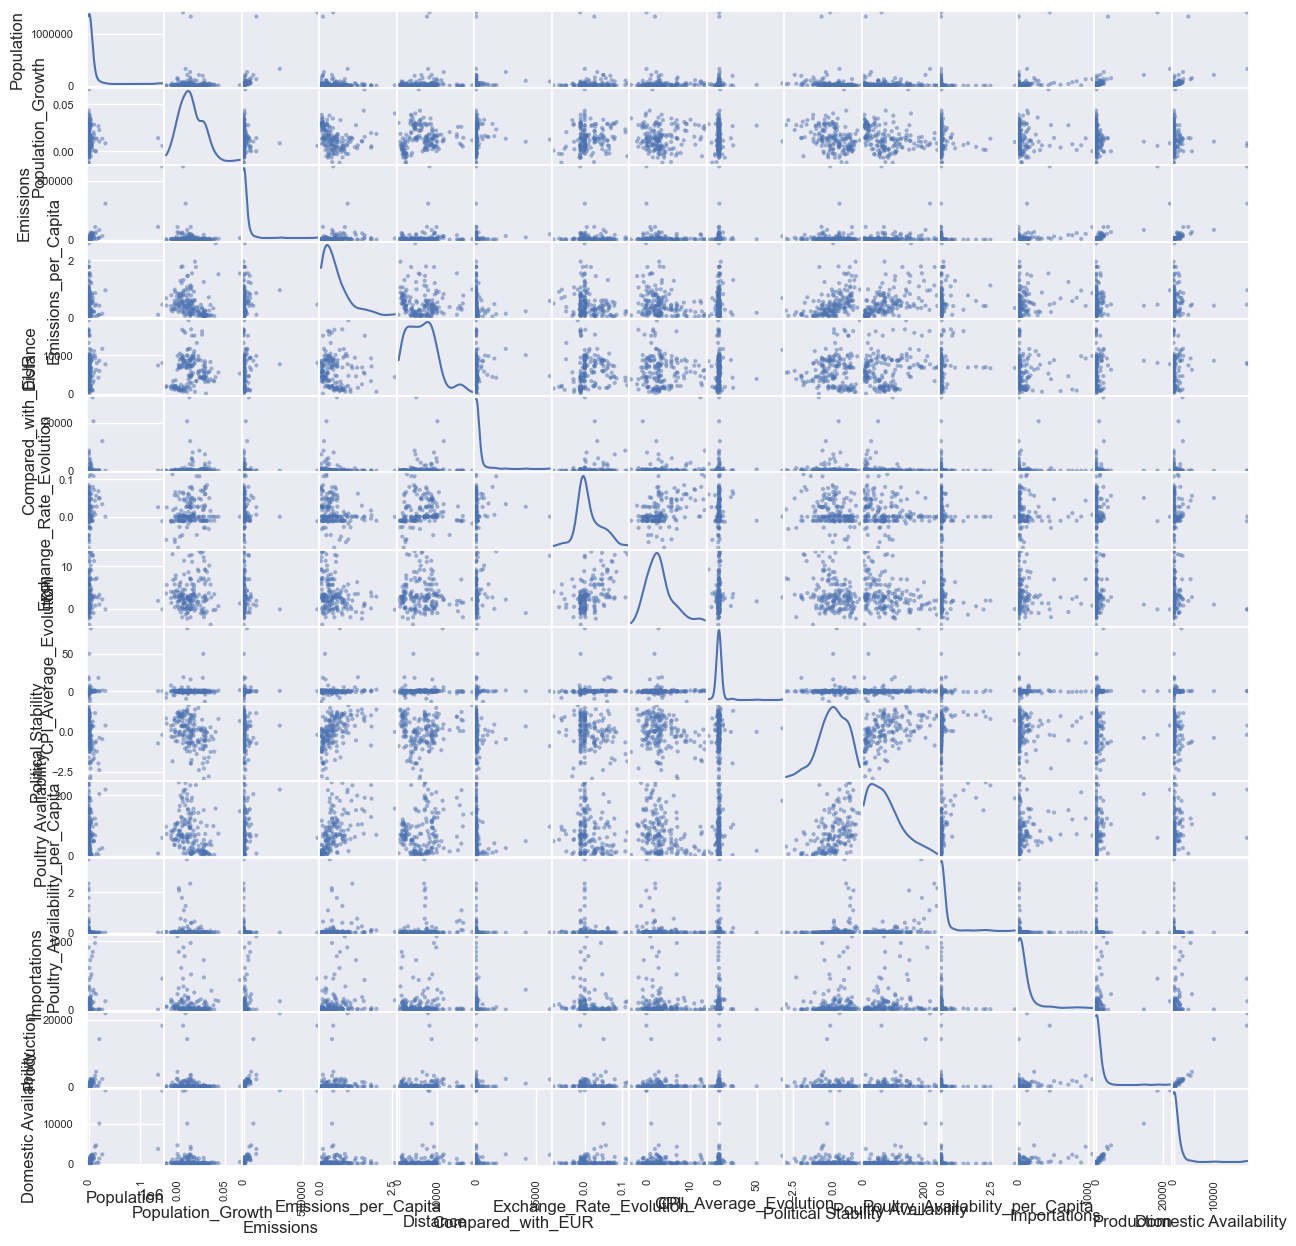

In [6]:
# Visualize pairwise scatter plot
print("\nPairwise Scatter plot:")
pd.plotting.scatter_matrix(X, diagonal='kde', figsize=(15, 15))
plt.show()

It's difficult to monitor all these displays at the same time. This type of representation is only useful for spotting atypical values. Overall, we have a few points that deviate from the groups.


Correlation Heatmap:


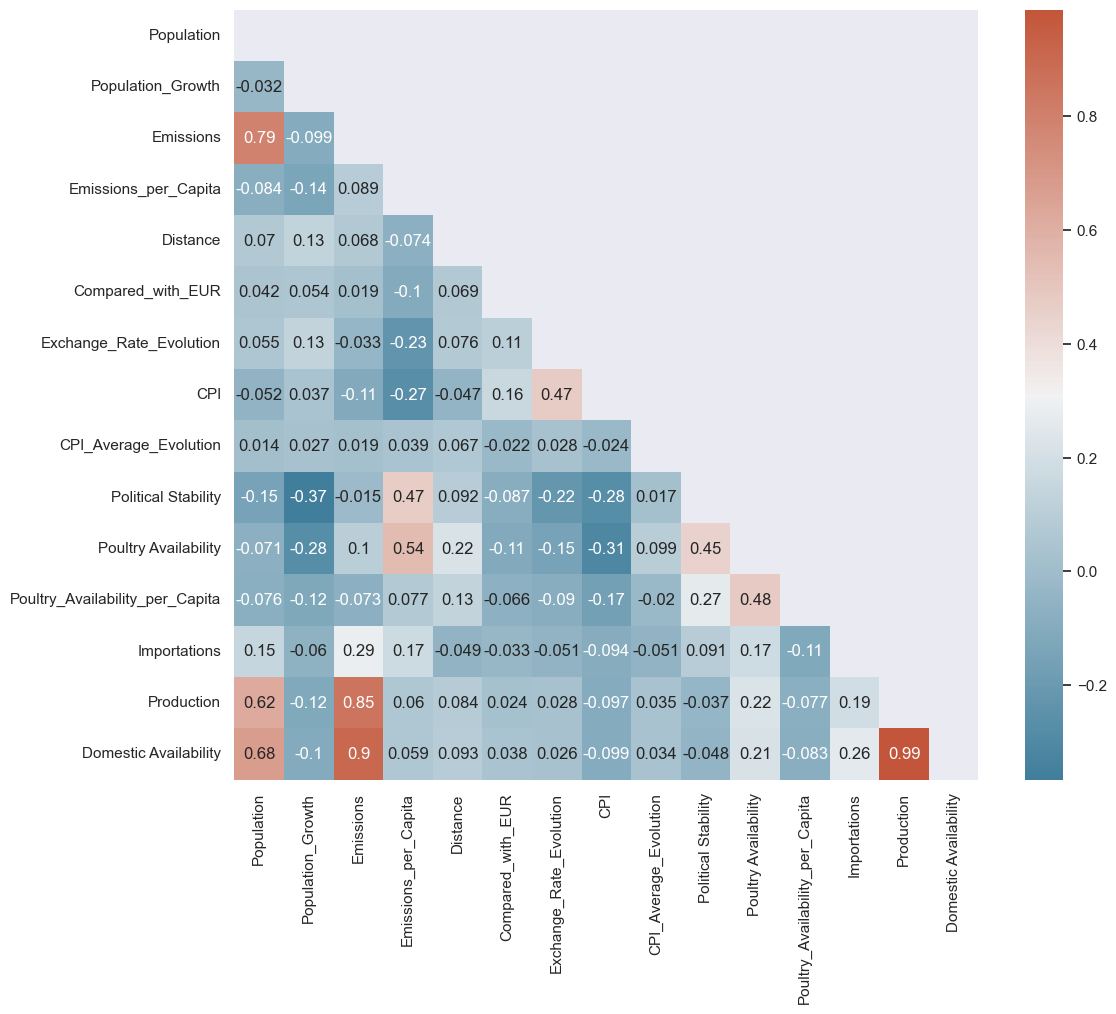

In [7]:
# Calculate pairwise correlation
corr = X.corr()

# Plot heatmap of correlation matrix
print("\nCorrelation Heatmap:")
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap)
plt.show();

- The domestic availability is strongly correlated with production.
- Political stability is correlated with emissions per capita.

## 3. Analyse<a class="anchor" id="partie3"></a>

### 3.1 Hierarchical Clustering

In [8]:
# Function to standardize features
def standardize_features(data):
    std_scale = preprocessing.StandardScaler().fit(data)
    scaled_data = std_scale.transform(data)
    return scaled_data, std_scale

In [9]:
# Function to characterize groups
def characterize_groups(data, groups):
    group_means = data.groupby(groups).mean()
    return group_means

In [10]:
# Function to print unique zones in groups
def print_unique_zones(data, group_number):
    group_data = data[data["Group"] == group_number]
    unique_zones = group_data["Zone"].unique()
    print(unique_zones)

In [11]:
def hierarchical_clustering_analysis(data, zones, k=6):
    # Standardize features
    X_scaled, std_scaler = standardize_features(data)

    # Calculate distances using Ward linkage
    Z = linkage(X_scaled, method="ward", metric="euclidean")

    # Simplified dendrogram with specified number of groups
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    _ = dendrogram(Z, p=k, truncate_mode="lastp", ax=ax, orientation="left")
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

    # Assign clusters and merge with original data
    clusters = fcluster(Z, k, criterion="maxclust")
    idg = np.argsort(clusters)
    dendo_clusters = pd.DataFrame(data.index[idg], clusters[idg]).reset_index()
    dendo_clusters = dendo_clusters.rename(columns={"index": "Group"})
    dendo_clusters = pd.merge(data, dendo_clusters, on="Zone")

    # Characterize the groups
    group_means = characterize_groups(dendo_clusters, "Group")
    display(group_means)

    # Print unique zones in each group
    for i in range(1, k + 1):  # Adjust range to start from 1 and end at k
        print(f"Group {i} Zones:")
        print_unique_zones(dendo_clusters, i)

    # Save and display geographical distribution of clusters
    df_dendo_subset = dendo_clusters.query("[1, 6] in Group") # Assuming 1 and 6 are the groups of interest
    df_dendo_subset.to_csv("df_dendo_subset.csv", index=False)
    df_dendo_subset.head(3)

    fig = px.choropleth(df_dendo_subset, locations=df_dendo_subset["Zone"], locationmode="country names", 
                        scope="world", color=df_dendo_subset["Group"],
                        color_discrete_sequence=px.colors.qualitative.Set2, basemap_visible=True, 
                        title="Geographical distribution of clusters obtained by hierarchical clustering")
    fig.show()

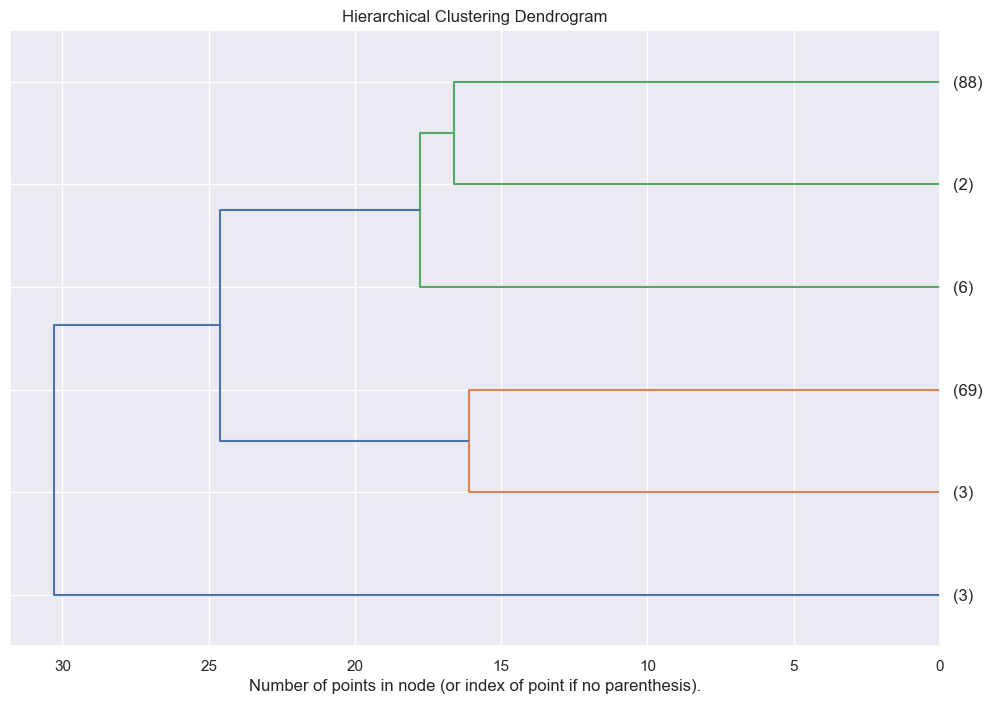

Population  Population_Growth      Emissions  Emissions_per_Capita  \
Group                                                                          
1      651313.456667           0.008022  337951.206600              0.594088   
2      146641.831333           0.011821   31966.334933              0.295659   
3       46136.439333           0.020357    5322.977925              0.193270   
4         103.430667           0.006419      65.626983              0.589604   
5       29678.247500           0.018714   15857.579550              0.410037   
6       18939.568602           0.009370   11625.516091              0.698576   

          Distance  Compared_with_EUR  Exchange_Rate_Evolution       CPI  \
Group                                                                      
1      8111.842948           3.358044                 0.012706  0.186837   
2      8806.186935       21153.013735                 0.020092  4.538711   
3      5498.331521         871.818916                 0.027249  5.056604   
4      6826.905709           2.484000                 0.000000  0.416710   
5      7644.108424         274.720950                -0.005166  2.170432   
6      6195.575611          94.966125                -0.000645  2.022642   

       CPI_Average_Evolution  Political Stability  Poultry Availability  \
Group                                                                     
1                   0.505013            -0.103333            160.666667   
2                   0.643668            -0.380000             56.333333   
3                  -0.068885            -0.673333             26.579710   
4                   0.146783             0.915000            208.166667   
5                  66.910921             0.060000             99.000000   
6                   0.483120             0.352159            100.000000   

       Poultry_Availability_per_Capita  Importations    Production  \
Group                                                                
1                             0.000566    192.666667  18117.000000   
2                             0.000597     99.333333   1797.666667   
3                             0.007598     36.086957    196.231884   
4                             2.244600      6.833333      0.333333   
5                             0.002590      4.000000   1119.000000   
6                             0.081479    128.397727    506.340909   

       Domestic Availability  
Group                         
1               15469.666667  
2                1916.333333  
3                 216.971014  
4                   7.000000  
5                1019.500000  
6                 523.954545

Group 1 Zones:
['Brazil' 'China' 'United States of America']
Group 2 Zones:
['Indonesia' 'Iran (Islamic Republic of)' 'Viet Nam']
Group 3 Zones:
['Afghanistan' 'Algeria' 'Angola' 'Bangladesh' 'Belarus' 'Benin'
 'Botswana' 'Burkina Faso' 'Cambodia' 'Cameroon'
 'Central African Republic' 'Chad' 'Congo' "Côte d'Ivoire"
 "Democratic People's Republic of Korea" 'Djibouti' 'Egypt' 'Eswatini'
 'Ethiopia' 'Gabon' 'Gambia' 'Georgia' 'Ghana' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Haiti' 'India' 'Iraq' 'Jordan' 'Kazakhstan' 'Kenya'
 'Kyrgyzstan' "Lao People's Democratic Republic" 'Lebanon' 'Lesotho'
 'Liberia' 'Madagascar' 'Malawi' 'Maldives' 'Mali' 'Mauritania' 'Moldova'
 'Mongolia' 'Mozambique' 'Namibia' 'Nepal' 'Niger' 'Nigeria' 'Pakistan'
 'Paraguay' 'Rwanda' 'Sao Tome and Principe' 'Serbia' 'Sierra Leone'
 'Sri Lanka' 'Sudan' 'Tajikistan' 'Togo' 'Tunisia' 'Turkey' 'Uganda'
 'Ukraine' 'United Republic of Tanzania' 'Uruguay' 'Uzbekistan' 'Yemen'
 'Zambia' 'Zimbabwe']
Group 4 Zones:
['Antigua a

In [12]:
# Execute the analysis
hierarchical_clustering_analysis(data=X, zones=X.index)

### 3.2 K-Means<a class="anchor" id="sous_partie3-2"></a>

In [13]:
def optimal_number_of_clusters(X):
    """
    Determine the optimal number of clusters using silhouette score.
    
    Parameters:
    - X: Input data
    
    Returns:
    - optimal_k: Optimal number of clusters
    """
    # Standardize features
    std_scale = preprocessing.StandardScaler().fit(X)
    W_scaled = std_scale.transform(X)

    silhouettes = []

    for k in range(2, 10):
        # KMeans clustering
        cls = cluster.KMeans(n_clusters=k)
        cls.fit(W_scaled)

        # Silhouette score
        silh = metrics.silhouette_score(W_scaled, cls.labels_)
        silhouettes.append(silh)

    # Find optimal k with maximum silhouette score
    optimal_k = np.argmax(silhouettes) + 2  # Add 2 to start from k=2

    # Plot Silhouette scores
    plt.plot(range(2, 10), silhouettes, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Score for Different Number of Clusters')
    plt.show()
    
    return optimal_k

In [14]:
def kmeans_clustering_analysis(X, n_clusters=None, random_state=None):
    """
    Perform KMeans clustering analysis on the given dataset and automatically select the optimal number of clusters.
    
    Parameters:
    - X: Original Dataset
    - n_clusters: Number of clusters. If None, the optimal number of clusters will be selected.
    - random_state: The seed used by the random number generator.
    
    Returns:
    - df_cls: DataFrame with clustering results
    - optimal_n_clusters: The optimal number of clusters selected
    """
    Xs = X.values
    std_scale = preprocessing.StandardScaler().fit(Xs)
    Xs_scaled = std_scale.transform(Xs)

    if n_clusters is None:
        silhouettes = []
        for k in range(2, 10):
            cls = cluster.KMeans(n_clusters=k)
            cls.fit(Xs_scaled)
            silh = metrics.silhouette_score(Xs_scaled, cls.labels_)
            silhouettes.append(silh)
        optimal_n_clusters = np.argmax(silhouettes) + 2  # Add 2 because range starts from 2
    else:
        optimal_n_clusters = n_clusters
    
    # Plot Silhouette scores
    plt.plot(range(2, 10), silhouettes, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Score for Different Number of Clusters')
    plt.show()
    
    cls = cluster.KMeans(n_clusters=optimal_n_clusters, random_state=random_state)
    cls.fit(Xs_scaled)

    centroids = cls.cluster_centers_
    centroid_std_scale = preprocessing.StandardScaler().fit(centroids)
    centroids_scaled = centroid_std_scale.transform(centroids)

    df_centroides = pd.DataFrame(centroids_scaled, columns=X.columns)

    idk = np.argsort(cls.labels_)
    df_cls = pd.DataFrame(X.index[idk], cls.labels_[idk]).reset_index()
    df_cls = df_cls.rename(columns={"index": "Cluster"})
    df_cls = pd.merge(X, df_cls, on="Zone")

    return df_cls, optimal_n_clusters

In [15]:
def plot_heatmap(centroids_scaled, feature_names, optimal_n_clusters):
    """
    Plot heatmap showing the cross-tabulation between country clusters and different variables.
    
    Parameters:
    - centroids_scaled: Scaled centroids
    - feature_names: List of feature names
    - optimal_n_clusters: Number of clusters
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(centroids_scaled[:, :-2], 
                yticklabels=[f"Cluster {i}" for i in range(optimal_n_clusters)], 
                xticklabels=feature_names[:-2], cmap='coolwarm', annot=True, fmt=".2f")
    plt.ylabel("Clusters")
    plt.xlabel("Variables")
    plt.title("Heatmap of K-Means Centroids")
    plt.show()

In [16]:
def display_cluster_zones(df_cls):
    """
    Display unique zones in each cluster.
    
    Parameters:
    - df_cls: DataFrame with clustering results
    """
    for i in range(df_cls["Cluster"].nunique()):
        print(f"Cluster {i} Zones:")
        print(df_cls[df_cls["Cluster"] == i]["Zone"].unique())

In [17]:
def visualize_clusters_on_map(df_cls):
    """
    Visualize geographical distribution of clusters on a map.
    
    Parameters:
    - df_cls: DataFrame with clustering results
    """
    # Calculate the K-Means centroids
    centroids = df_cls.groupby('Cluster')[['Importations', 'Poultry_Availability_per_Capita']].mean()
    
    # Find clusters with highest centroids values for Importations and Poultry_Availability_per_Capita
    top_clusters = centroids.nlargest(2, ['Importations', 'Poultry_Availability_per_Capita']).index.tolist()
    
    # Filter the DataFrame to select rows corresponding to top clusters
    cls_subset_monde = df_cls[df_cls['Cluster'].isin(top_clusters)]
    
    # Save filtered DataFrame
    cls_subset_monde.to_csv("cls_subset_monde.csv", index=False)
    
    # Visualize geographical distribution of selected clusters on map
    fig = px.choropleth(cls_subset_monde, locations="Zone", locationmode="country names", 
                        scope="world", color="Cluster",
                        color_discrete_sequence=px.colors.qualitative.Set2, basemap_visible=True, 
                        title="Geographical distribution of K-Means clusters")
    fig.show()

In [18]:
def test_normality(data, test="ks"):
    """
    Test the normality of a given dataset.
    
    Parameters:
    - data: Input data
    - test: Type of normality test to perform. Options: "ks" (Kolmogorov-Smirnov) or "shapiro" (Shapiro-Wilk)
    
    Returns:
    - stat: Test statistic
    - p: p-value
    """
    if test == "ks":
        stat, p = ks_2samp(data, list(np.random.normal(np.mean(data), np.std(data), 1000)))
    elif test == "shapiro":
        stat, p = shapiro(data)
    else:
        raise ValueError("Invalid test type. Choose 'ks' for Kolmogorov-Smirnov or 'shapiro' for Shapiro-Wilk.")
    
    return stat, p

In [19]:
def main(X, random_state=None):
    """
    Perform KMeans clustering analysis with the optimal number of clusters.
    
    Parameters:
    - X: Input data
    """
    Xs = X.values
    
    # Perform KMeans clustering analysis with the optimal number of clusters
    df_cls, optimal_n_clusters = kmeans_clustering_analysis(X)
    print("Optimal number of clusters:", optimal_n_clusters)
    
    # Test normality with Kolmogorov-Smirnov
    stat_ks, p_ks = test_normality(X["Poultry_Availability_per_Capita"], test="ks")
    print("\nKolmogorov-Smirnov Test:")
    print("Statistics=%.3f, p=%.3f" % (stat_ks, p_ks))
    if p_ks > 0.05:
        print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
    else:
        print("Reject the null hypothesis (H0) at a 5% significance level.")

    # Test normality with Shapiro-Wilk
    stat_shapiro, p_shapiro = test_normality(X["Poultry_Availability_per_Capita"], test="shapiro")
    print("\nShapiro-Wilk Test:")
    print("Statistics=%.3f, p=%.3f" % (stat_shapiro, p_shapiro))
    if p_shapiro > 0.05:
        print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
    else:
        print("Reject the null hypothesis (H0) at a 5% significance level.")
        
    std_scale = preprocessing.StandardScaler().fit(Xs)
    Xs_scaled = std_scale.transform(Xs)

    # PCA
    pcas = decomposition.PCA(svd_solver="full")
    pcas.fit(Xs_scaled)
    
    pcs = pcas.components_

    # Display PCA
    plt.figure(figsize=(10, 10))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), pcs[0, :], pcs[1, :], 
               angles='xy', scale_units='xy', scale=1, color='r', width=0.003)
    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        plt.text(x, y, X.columns[i])
    circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="b")
    plt.gca().add_artist(circle)
    plt.plot([-1, 1], [0, 0], color='silver', linestyle='--', linewidth=1)
    plt.plot([0, 0], [-1, 1], color='silver', linestyle='--', linewidth=1)
    plt.title("Correlation circle", fontsize=20)
    plt.xlabel("F{} ({}%)".format(1, round(100 * pcas.explained_variance_ratio_[0], 1)))
    plt.ylabel("F{} ({}%)".format(2, round(100 * pcas.explained_variance_ratio_[1], 1)))
    plt.show()
    
    # Perform KMeans clustering with optimal number of clusters
    cls = cluster.KMeans(n_clusters=optimal_n_clusters, random_state=random_state)
    cls.fit(Xs_scaled)
    Xs_projected = pcas.transform(Xs_scaled)
    
    plt.figure(figsize=(20, 10))
    plt.scatter(Xs_projected[:, 0], Xs_projected[:, 1], c=cls.labels_)
    plt.xlabel("F{} ({}%)".format(1, round(100 * pcas.explained_variance_ratio_[0], 1)))
    plt.ylabel("F{} ({}%)".format(2, round(100 * pcas.explained_variance_ratio_[1], 1)))
    plt.title("Projection in {} clusters on the 1st factorial plane".format(optimal_n_clusters))
    plt.show()

    centroids = cls.cluster_centers_
    centroid_std_scale = preprocessing.StandardScaler().fit(centroids)
    centroids_scaled = centroid_std_scale.transform(centroids)

    plot_heatmap(centroids_scaled, X.columns, optimal_n_clusters)
    display_cluster_zones(df_cls)
    visualize_clusters_on_map(df_cls)
    
    return df_cls, optimal_n_clusters

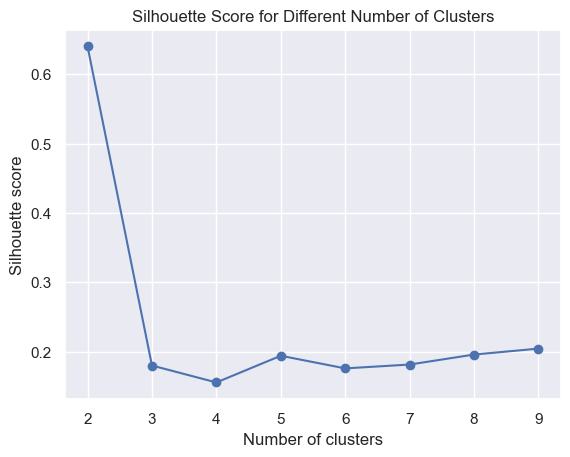

Optimal number of clusters: 2

Kolmogorov-Smirnov Test:
Statistics=0.425, p=0.000
Reject the null hypothesis (H0) at a 5% significance level.

Shapiro-Wilk Test:
Statistics=0.298, p=0.000
Reject the null hypothesis (H0) at a 5% significance level.


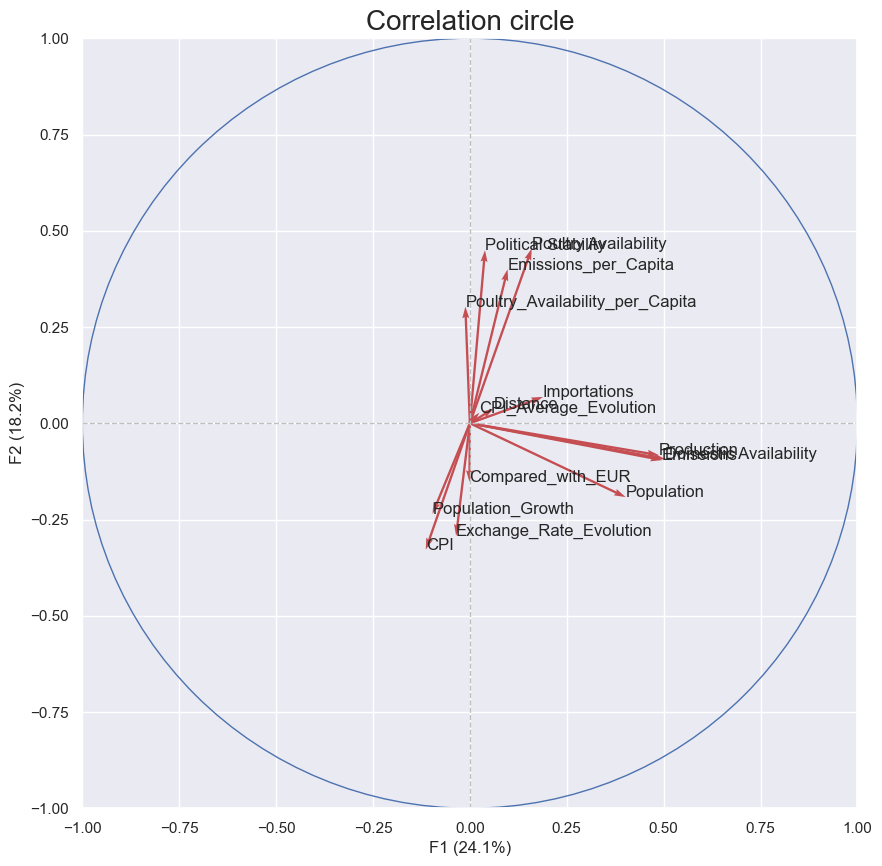

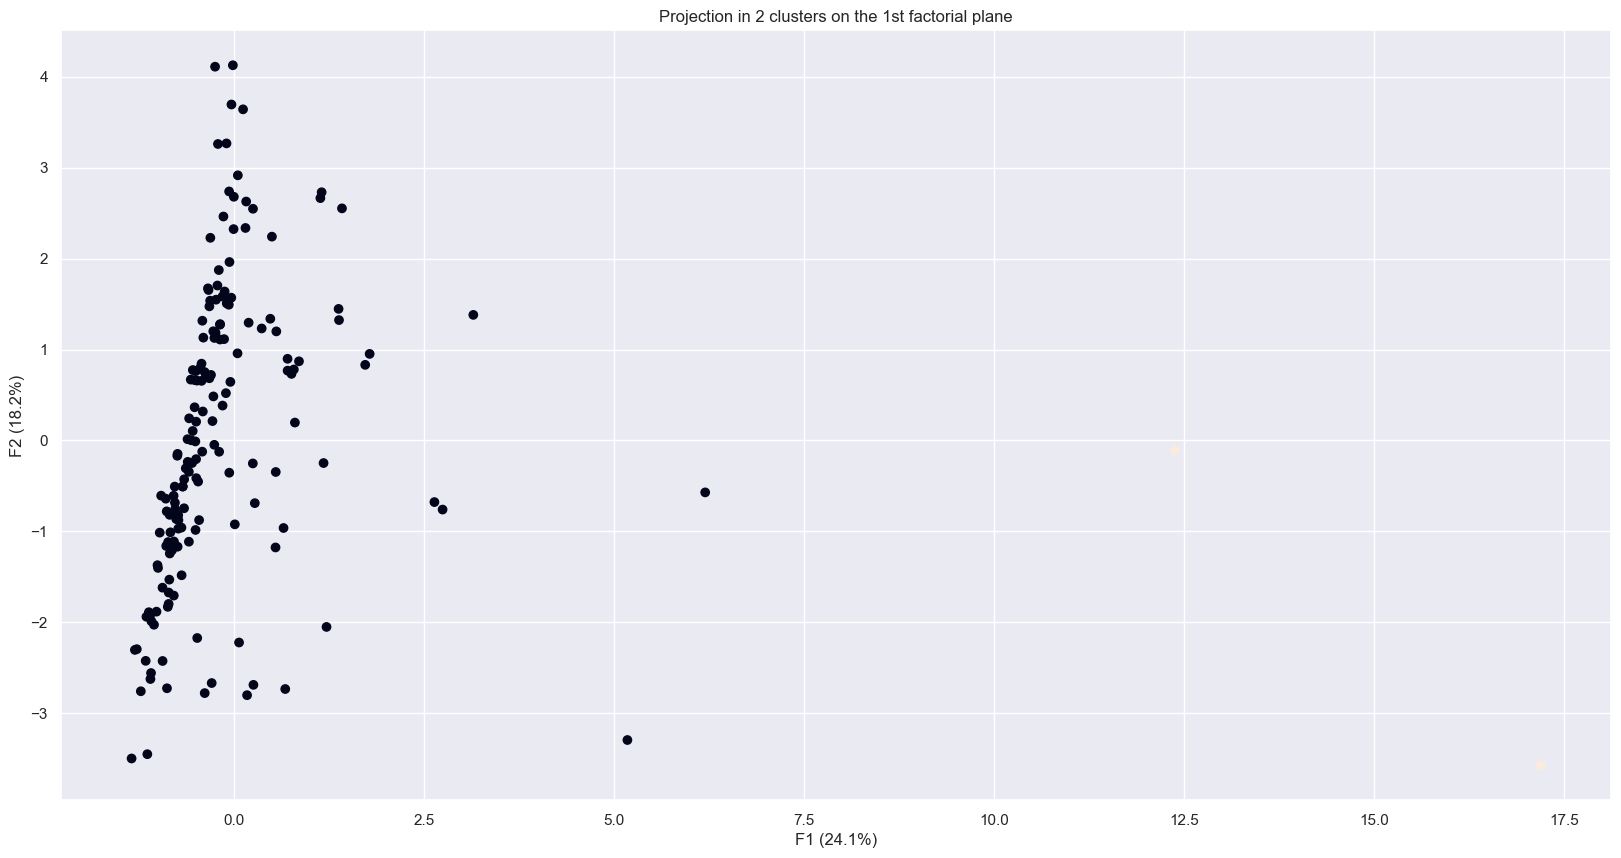

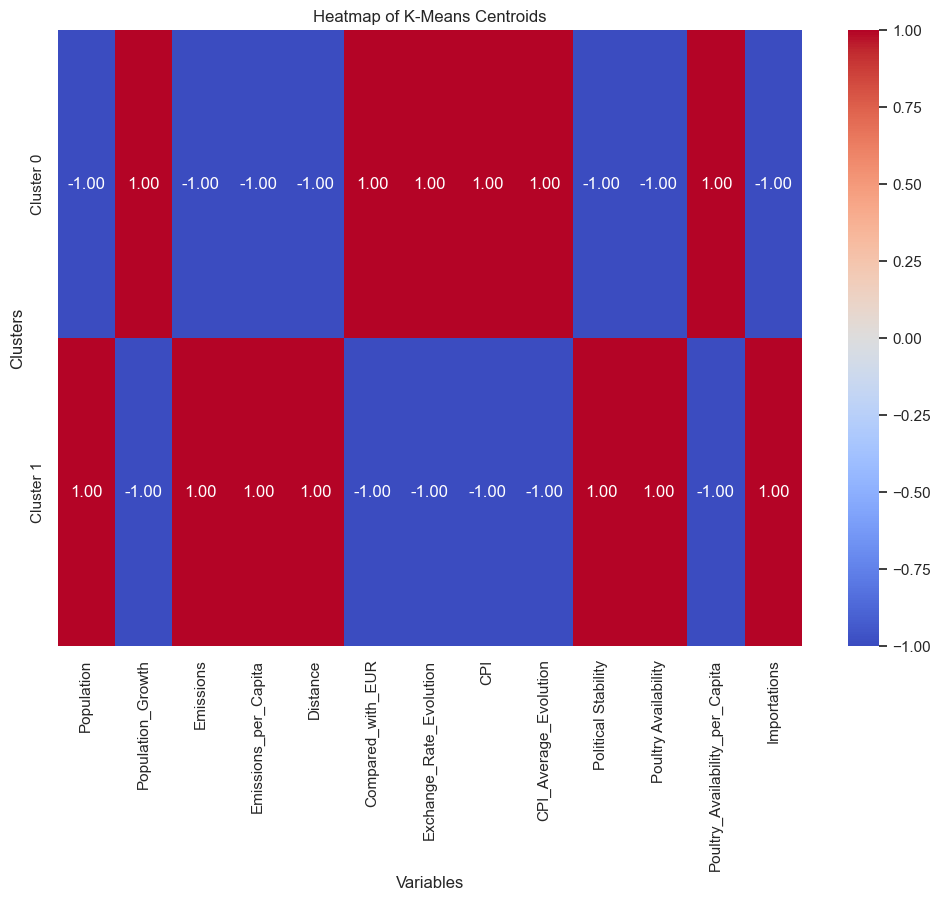

Cluster 0 Zones:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China - Hong-Kong'
 'China - Macao' 'Colombia' 'Congo' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Côte d'Ivoire" "Democratic People's Republic of Korea"
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Iceland' 'Indonesia' 'Iran (Islamic Republic of)'
 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kiriba

In [20]:
df_cls, optimal_n_clusters = main(X)

### 3.3 Further analysis

To fine-tune the result, the variables that seems less correlated to F1 and F2 will be removed.

In [21]:
def remove_variables(X):
    """
    Remove multiple variables from the dataset X.
    
    Parameters:
    - X: Input data
    
    Returns:
    - X_subset: Dataset with two variables removed
    """
    X_subset = X[["Poultry_Availability_per_Capita", "Domestic Availability", "Importations", 
                  "Political Stability", "Compared_with_EUR", "Exchange_Rate_Evolution", "CPI_Average_Evolution"]]
    return X_subset

In [22]:
def main(X, random_state=None):
    """
    Main function to execute the analysis steps.
    
    Parameters:
    - X: Input data
    
    Returns:
    - None
    """
    X_subset = remove_variables(X)
    Xs = X_subset.values
    
    # Get the optimal number of clusters from kmeans_clustering_analysis
    df_cls, optimal_n_clusters = kmeans_clustering_analysis(X_subset)
    print("Optimal number of clusters:", optimal_n_clusters)
    
    # Test normality with Kolmogorov-Smirnov
    stat_ks, p_ks = test_normality(X_subset["Poultry_Availability_per_Capita"], test="ks")
    print("\nKolmogorov-Smirnov Test:")
    print("Statistics=%.3f, p=%.3f" % (stat_ks, p_ks))
    if p_ks > 0.05:
        print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
    else:
        print("Reject the null hypothesis (H0) at a 5% significance level.")

    # Test normality with Shapiro-Wilk
    stat_shapiro, p_shapiro = test_normality(X_subset["Poultry_Availability_per_Capita"], test="shapiro")
    print("\nShapiro-Wilk Test:")
    print("Statistics=%.3f, p=%.3f" % (stat_shapiro, p_shapiro))
    if p_shapiro > 0.05:
        print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
    else:
        print("Reject the null hypothesis (H0) at a 5% significance level.")
        
    std_scale = preprocessing.StandardScaler().fit(Xs)
    Xs_scaled = std_scale.transform(Xs)
    
    pcas = decomposition.PCA(svd_solver="full")
    pcas.fit(Xs_scaled)
    
    pcs = pcas.components_
    
    # Display PCA
    plt.figure(figsize=(10, 10))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), pcs[0, :], pcs[1, :], 
               angles='xy', scale_units='xy', scale=1, color='r', width=0.003)
    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        plt.text(x, y, X_subset.columns[i])
    circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="b")
    plt.gca().add_artist(circle)
    plt.plot([-1, 1], [0, 0], color='silver', linestyle='--', linewidth=1)
    plt.plot([0, 0], [-1, 1], color='silver', linestyle='--', linewidth=1)
    plt.title("Correlation circle", fontsize=20)
    plt.xlabel("F{} ({}%)".format(1, round(100 * pcas.explained_variance_ratio_[0], 1)))
    plt.ylabel("F{} ({}%)".format(2, round(100 * pcas.explained_variance_ratio_[1], 1)))
    plt.show()
    
    # Perform KMeans clustering with optimal number of clusters
    cls = cluster.KMeans(n_clusters=optimal_n_clusters, random_state=random_state)
    cls.fit(Xs_scaled)
    Xs_projected = pcas.transform(Xs_scaled)
    
    plt.figure(figsize=(20, 10))
    plt.scatter(Xs_projected[:, 0], Xs_projected[:, 1], c=cls.labels_)
    plt.xlabel("F{} ({}%)".format(1, round(100 * pcas.explained_variance_ratio_[0], 1)))
    plt.ylabel("F{} ({}%)".format(2, round(100 * pcas.explained_variance_ratio_[1], 1)))
    plt.title("Projection in {} clusters on the 1st factorial plane".format(optimal_n_clusters))
    plt.show()
    
    centroids = cls.cluster_centers_
    centroid_std_scale = preprocessing.StandardScaler().fit(centroids)
    centroids_scaled = centroid_std_scale.transform(centroids)
    
    plot_heatmap(centroids_scaled, X_subset.columns, optimal_n_clusters)
    display_cluster_zones(df_cls)
    visualize_clusters_on_map(df_cls)
    
    return df_cls, optimal_n_clusters

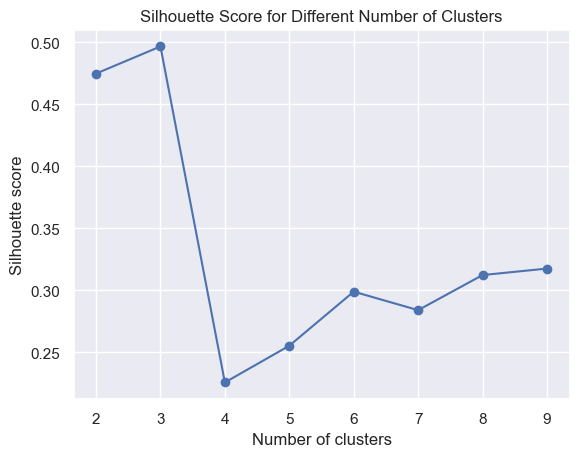

Optimal number of clusters: 3

Kolmogorov-Smirnov Test:
Statistics=0.399, p=0.000
Reject the null hypothesis (H0) at a 5% significance level.

Shapiro-Wilk Test:
Statistics=0.298, p=0.000
Reject the null hypothesis (H0) at a 5% significance level.


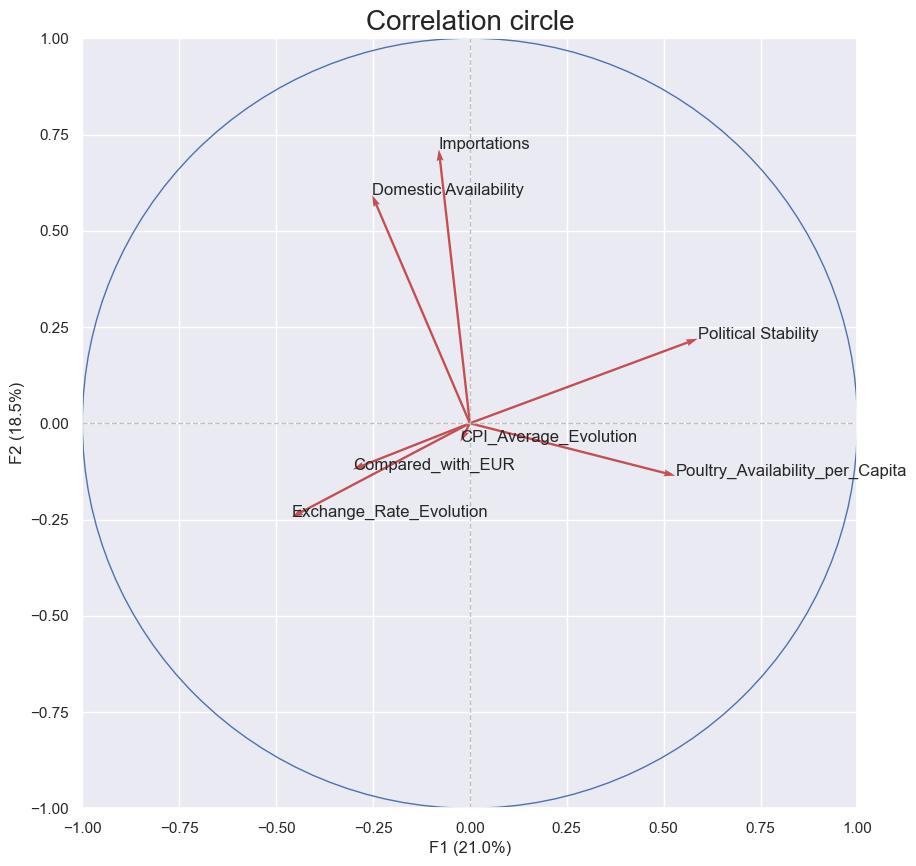

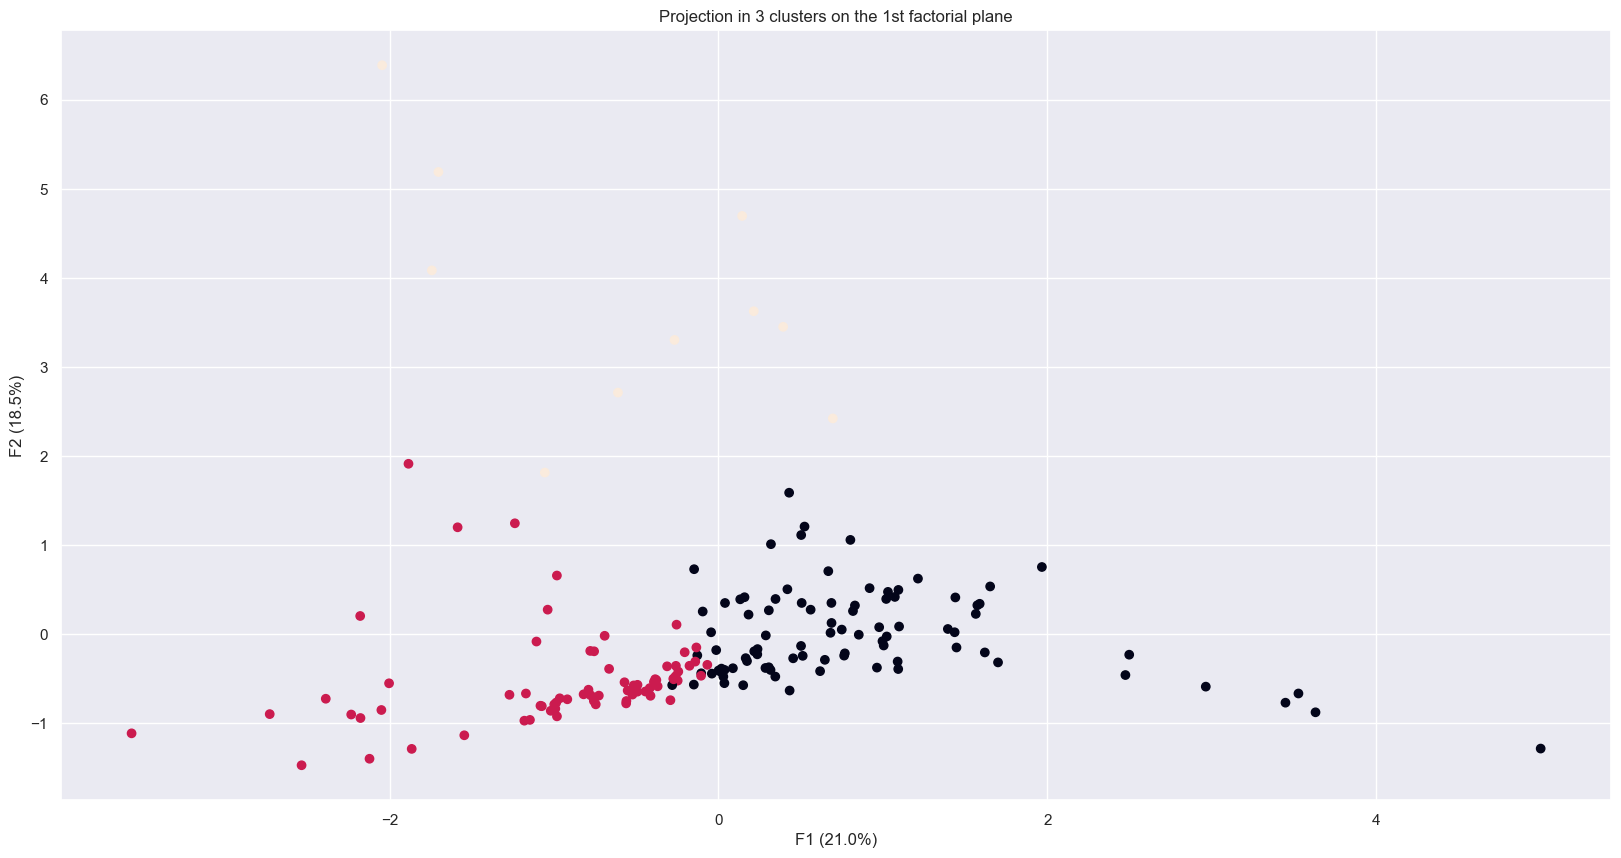

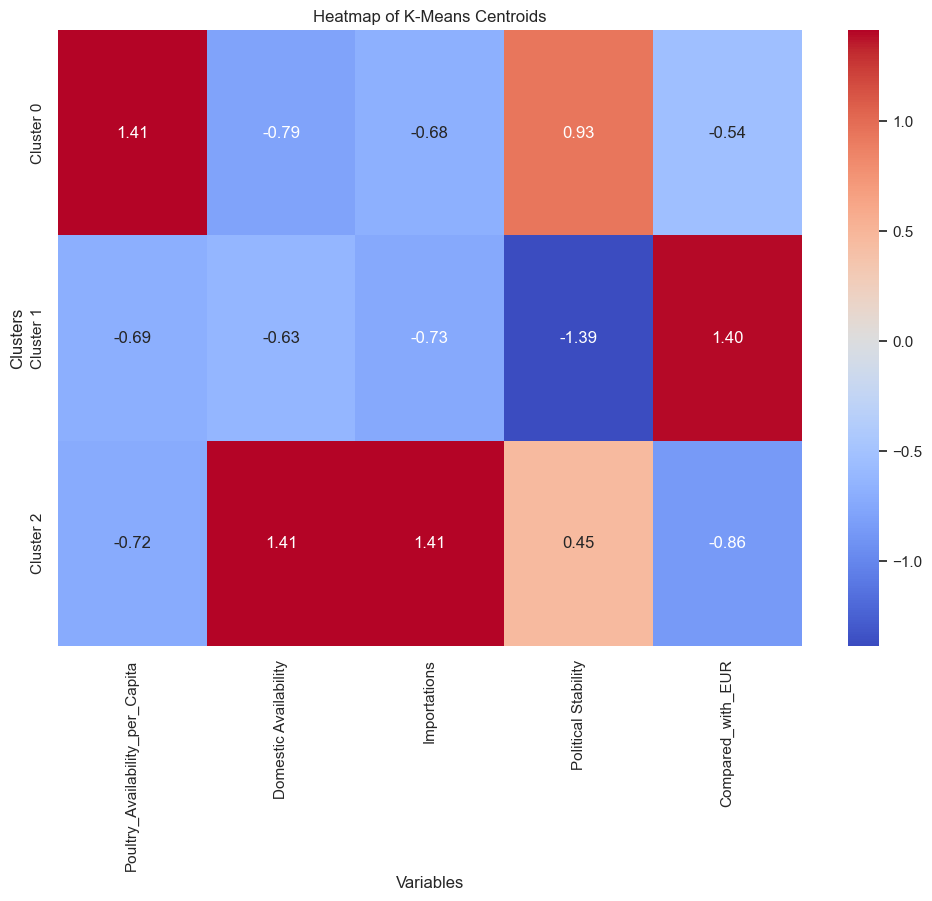

Cluster 0 Zones:
['Afghanistan' 'Algeria' 'Angola' 'Armenia' 'Azerbaijan' 'Bangladesh'
 'Belarus' 'Bolivia (Plurinational State of)' 'Burkina Faso' 'Cambodia'
 'Cameroon' 'Central African Republic' 'Chad' 'Colombia' 'Congo'
 "Côte d'Ivoire" "Democratic People's Republic of Korea" 'Djibouti'
 'Dominican Republic' 'Egypt' 'Eswatini' 'Ethiopia' 'Gambia' 'Georgia'
 'Ghana' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Honduras' 'India'
 'Indonesia' 'Iran (Islamic Republic of)' 'Iraq' 'Israel' 'Jamaica'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Lebanon' 'Lesotho' 'Liberia'
 'Madagascar' 'Malawi' 'Mali' 'Moldova' 'Mongolia' 'Morocco' 'Mozambique'
 'Myanmar' 'Nepal' 'Nicaragua' 'Niger' 'Nigeria' 'Pakistan' 'Paraguay'
 'Peru' 'Philippines' 'Russian Federation' 'Rwanda' 'Serbia'
 'Sierra Leone' 'Solomon Islands' 'Sri Lanka' 'Sudan' 'Suriname'
 'Tajikistan' 'Thailand' 'Togo' 'Tunisia' 'Turkey' 'Turkmenistan' 'Uganda'
 'Ukraine' 'United Republic of Tanzania'

In [23]:
# Call main function
df_cls1, optimal_n_clusters1 = main(X)

### 3.4 Clustering countries closer to France

Let's take only countries within 3,000 km of France.

In [25]:
def filter_and_remove_variables(X, max_distance=3000):
    """
    Filter countries within the specified maximum distance from France and remove specific variables.
    Parameters:
    - X: Input data
    - max_distance: Maximum distance in kilometers from France (default is 3000)
    Returns:
    - X_subset: Dataset with filtered countries and removed variables
    """
    distance_filtered = X[X["Distance"] <= max_distance]
    X_subset = distance_filtered[["Poultry_Availability_per_Capita", "Domestic Availability", "Importations", 
                    "Production", "Production", "Political Stability", "Distance", "Compared_with_EUR", "CPI_Average_Evolution"]]
    
    return X_subset

In [26]:
def main(X, random_state=None):
    """
    Main function to execute the analysis steps.
    Parameters:
    - X: Input data
    Returns:
    - None
    """
    X_subset = filter_and_remove_variables(X)
    Xs = X_subset.values
    
    # Get the optimal number of clusters from kmeans_clustering_analysis
    df_cls, optimal_n_clusters = kmeans_clustering_analysis(X_subset)
    print("Optimal number of clusters:", optimal_n_clusters)
    
    # Test normality with Kolmogorov-Smirnov
    stat_ks, p_ks = test_normality(X_subset["Poultry_Availability_per_Capita"], test="ks")
    print("\nKolmogorov-Smirnov Test:")
    print("Statistics=%.3f, p=%.3f" % (stat_ks, p_ks))
    if p_ks > 0.05:
        print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
    else:
        print("Reject the null hypothesis (H0) at a 5% significance level.")

    # Test normality with Shapiro-Wilk
    stat_shapiro, p_shapiro = test_normality(X_subset["Poultry_Availability_per_Capita"], test="shapiro")
    print("\nShapiro-Wilk Test:")
    print("Statistics=%.3f, p=%.3f" % (stat_shapiro, p_shapiro))
    if p_shapiro > 0.05:
        print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
    else:
        print("Reject the null hypothesis (H0) at a 5% significance level.")
          
    std_scale = preprocessing.StandardScaler().fit(Xs)
    Xs_scaled = std_scale.transform(Xs)

    pcas = decomposition.PCA(svd_solver="full")
    pcas.fit(Xs_scaled)

    pcs = pcas.components_

    plt.figure(figsize=(10, 10))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), pcs[0, :], pcs[1, :], 
               angles='xy', scale_units='xy', scale=1, color='r', width=0.003)
    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        plt.text(x, y, X_subset.columns[i])
    circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="b")
    plt.gca().add_artist(circle)
    plt.plot([-1, 1], [0, 0], color='silver', linestyle='--', linewidth=1)
    plt.plot([0, 0], [-1, 1], color='silver', linestyle='--', linewidth=1)
    plt.title("Correlation circle", fontsize=20)
    plt.xlabel("F{} ({}%)".format(1, round(100 * pcas.explained_variance_ratio_[0], 1)))
    plt.ylabel("F{} ({}%)".format(2, round(100 * pcas.explained_variance_ratio_[1], 1)))
    plt.show()

    # Perform KMeans clustering with optimal number of clusters
    cls = cluster.KMeans(n_clusters=optimal_n_clusters, random_state=random_state)
    cls.fit(Xs_scaled)
    Xs_projected = pcas.transform(Xs_scaled)

    plt.figure(figsize=(20, 10))
    plt.scatter(Xs_projected[:, 0], Xs_projected[:, 1], c=cls.labels_)
    plt.xlabel("F{} ({}%)".format(1, round(100 * pcas.explained_variance_ratio_[0], 1)))
    plt.ylabel("F{} ({}%)".format(2, round(100 * pcas.explained_variance_ratio_[1], 1)))
    plt.title("Projection in {} clusters on the 1st factorial plane".format(optimal_n_clusters))
    plt.show()

    centroids = cls.cluster_centers_
    centroid_std_scale = preprocessing.StandardScaler().fit(centroids)
    centroids_scaled = centroid_std_scale.transform(centroids)

    plot_heatmap(centroids_scaled, X_subset.columns, optimal_n_clusters)
    display_cluster_zones(df_cls)
    visualize_clusters_on_map(df_cls)
    
    return df_cls, optimal_n_clusters

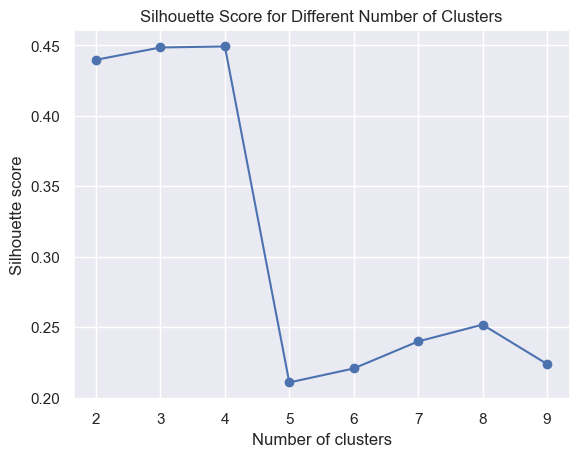

Optimal number of clusters: 4

Kolmogorov-Smirnov Test:
Statistics=0.320, p=0.000
Reject the null hypothesis (H0) at a 5% significance level.

Shapiro-Wilk Test:
Statistics=0.503, p=0.000
Reject the null hypothesis (H0) at a 5% significance level.


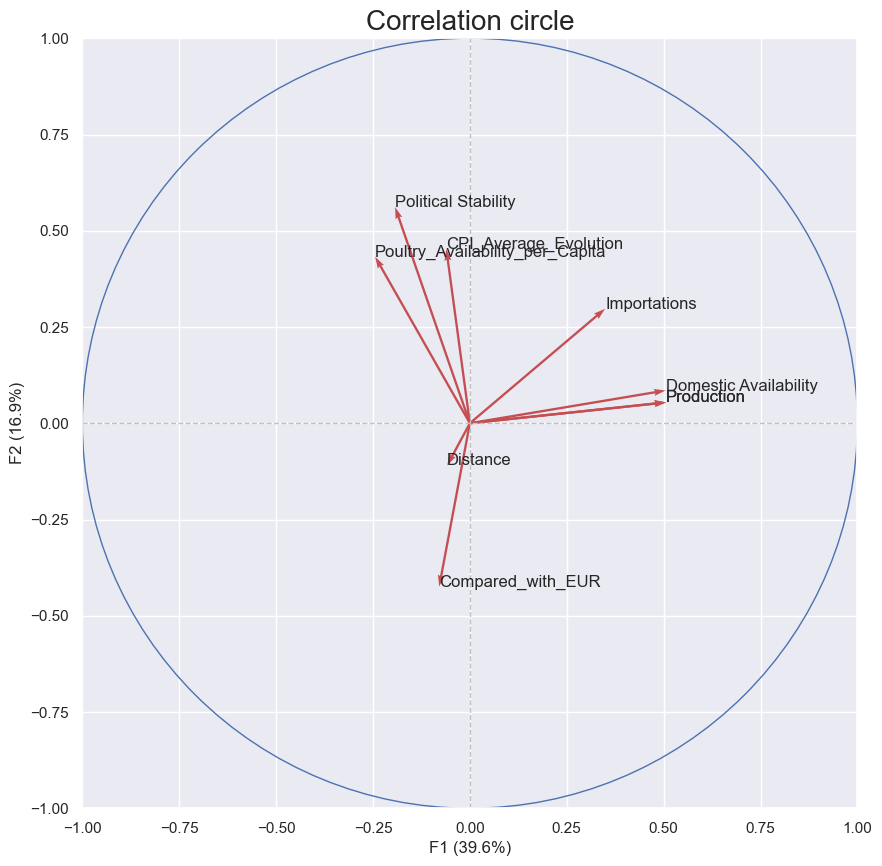

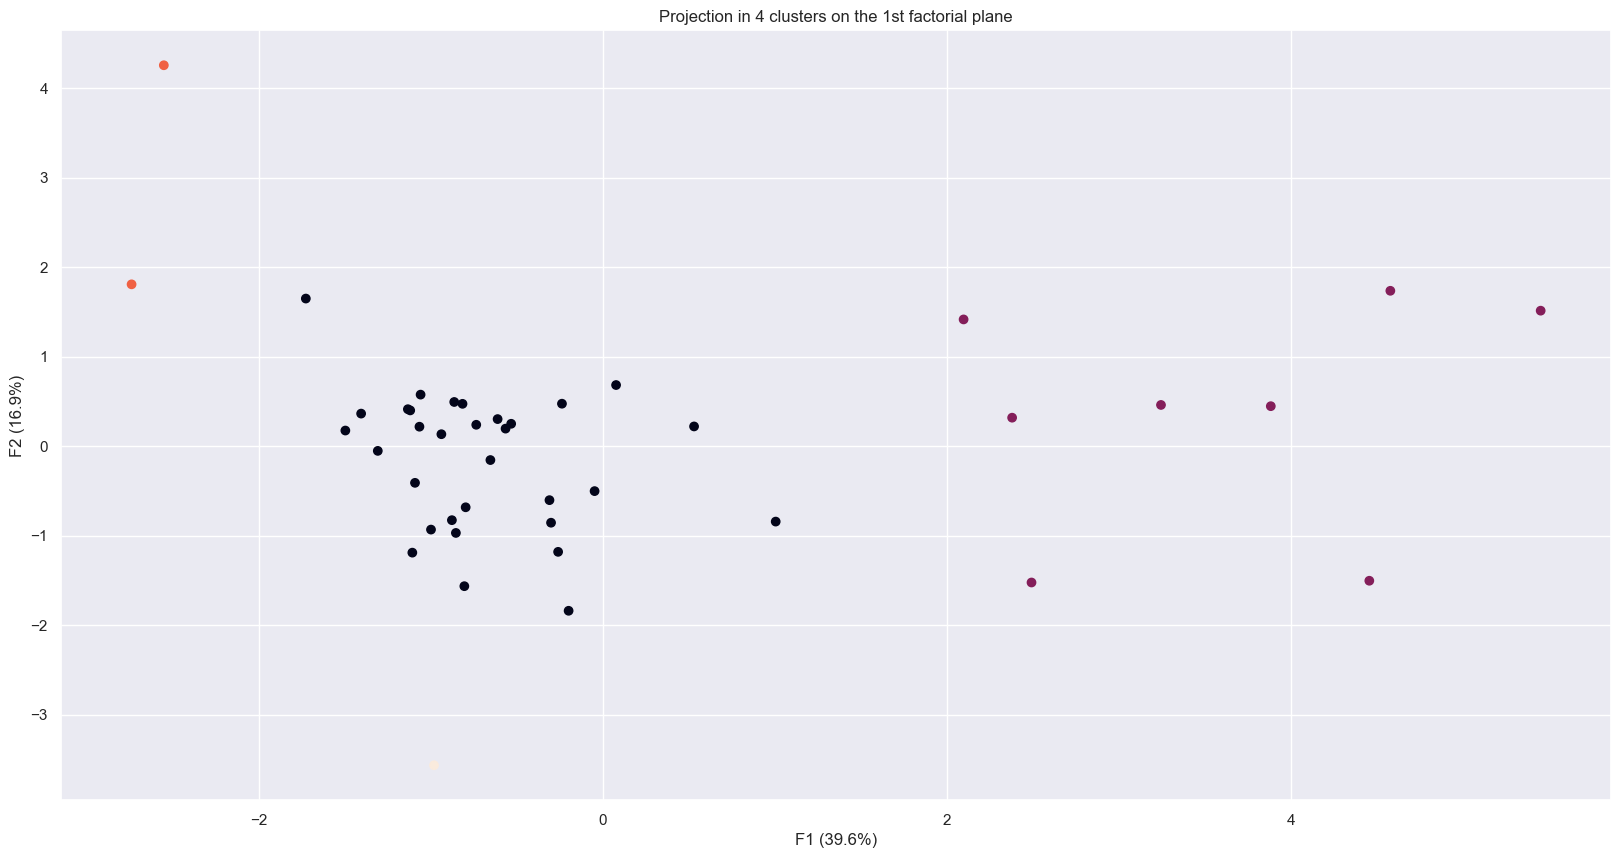

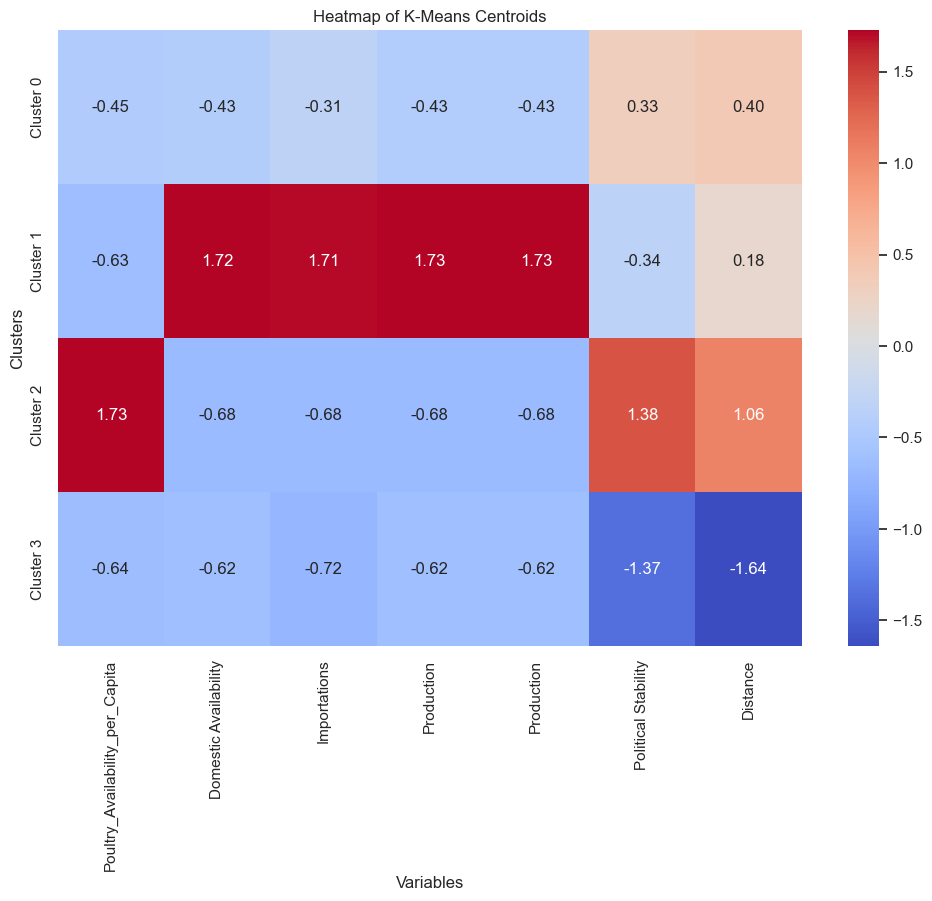

Cluster 0 Zones:
['Algeria' 'Belarus' 'Bosnia and Herzegovina' 'Bulgaria' 'Cyprus'
 'Estonia' 'Finland' 'Greece' 'Latvia' 'Moldova' 'Montenegro' 'Morocco'
 'North Macedonia' 'Romania' 'Tunisia' 'Ukraine']
Cluster 1 Zones:
['Germany' 'Italy' 'Netherlands' 'Poland' 'Spain' 'Turkey'
 'United Kingdom of Great Britain and Northern Ireland']
Cluster 2 Zones:
['Albania' 'Austria' 'Belgium' 'Burkina Faso' 'Croatia' 'Czechia'
 'Denmark' 'Hungary' 'Ireland' 'Lithuania' 'Luxembourg' 'Norway'
 'Portugal' 'Serbia' 'Slovakia' 'Slovenia' 'Sweden' 'Switzerland']
Cluster 3 Zones:
['Iceland' 'Malta']


In [27]:
# Call main function
df_cls2, optimal_n_clusters2 = main(X)

## 4. Are our groups really distinct?

In [29]:
def bartlett_test(df_cls1, df_cls2):
    """
    Perform Bartlett test to compare the within-group variances of two sets of clustering results.
    
    Parameters:
    - df_cls: DataFrame with clustering results (first set)
    - df_cls1: DataFrame with clustering results (second set)
    
    Returns:
    - p_value: p-value of the Bartlett test
    """
    # Calculate within-group variances for each cluster in df_cls
    within_group_variances = []
    for cluster_id in df_cls['Cluster'].unique():
        cluster_data = df_cls[df_cls1['Cluster'] == cluster_id]['Poultry_Availability_per_Capita']
        within_group_variances.append(cluster_data.var())

    # Calculate within-group variances for each cluster in df_cls1
    within_group_variances1 = []
    for cluster_id in df_cls1['Cluster'].unique():
        cluster_data = df_cls1[df_cls1['Cluster'] == cluster_id]['Poultry_Availability_per_Capita']
        within_group_variances1.append(cluster_data.var())

    # Perform Bartlett test
    _, p_value = bartlett(within_group_variances, within_group_variances1)
    
    return p_value

In [30]:
# Call the Bartlett test function
p_value = bartlett_test(df_cls, df_cls1)
print("Bartlett Test p-value:", p_value)
if p_value > 0.05:
    print("Cannot reject the null hypothesis (H0) at a 5% significance level.")
else:
    print("Reject the null hypothesis (H0) at a 5% significance level.")

Bartlett Test p-value: 1.0
Cannot reject the null hypothesis (H0) at a 5% significance level.
